# Project Title
### Data Engineering Capstone Project

#### Project Summary
This project involves building a data warehouse with fact and dimension tables by integrating I94 immigration data, world temperature data and US demographic data.


The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Do all imports and installs here
import os
import pandas as pd, re
from datetime import datetime
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf

### Step 1: Scope the Project and Gather Data

#### Scope 
This project integrates [I94 Immigration Data](https://travel.trade.gov/research/reports/i94/historical/2016.html), [World Temperature Data](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data) and [U.S. City Demographic Data](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/) to setup a data warehouse with fact and dimension tables
* Tools
    * AWS S3: data storage
    * Python for data processing
           * Pandas - EDA on small dataset
           * PySpark - Processing large datasets
#### Describe and Gather Data 
| Data Set | Format | Description |
| ---      | ---    | ---         |
|[I94 Immigration Data](https://travel.trade.gov/research/reports/i94/historical/2016.html)| SAS | This data comes from the US National Tourism and Trade Office and contains international visitor arrival statistics by world regions and select countries and other data points|
|[World Temperature Data](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data)| CSV | This dataset comes from Kaggle and contains monthly average temperature data for different countries|
|[U.S. City Demographic Data](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/)| CSV | This data comes from OpenSoft and shows demographics of all US cities and census-designated places with a population greater or equal to 65,000.|

### EDA Immigration Dataset

In [2]:
immigration_path = '../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'
immigration_df = pd.read_sas(immigration_path, 'sas7bdat', encoding="ISO-8859-1")

In [4]:
pd.set_option('display.max_columns', None)
immigration_df.head()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,XXX,20573.0,NaN,NaN,NaN,37.0,2.0,1.0,NaN,NaN,NaN,T,NaN,U,NaN,1979.0,10282016,NaN,NaN,NaN,1.897628e+09,NaN,B2
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,NaN,25.0,3.0,1.0,20130811,SEO,NaN,G,NaN,Y,NaN,1991.0,D/S,M,NaN,NaN,3.736796e+09,00296,F1
2,15.0,2016.0,4.0,101.0,101.0,WAS,20545.0,1.0,MI,20691.0,55.0,2.0,1.0,20160401,NaN,NaN,T,O,NaN,M,1961.0,09302016,M,NaN,OS,6.666432e+08,93,B2
3,16.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,28.0,2.0,1.0,20160401,NaN,NaN,O,O,NaN,M,1988.0,09302016,NaN,NaN,AA,9.246846e+10,00199,B2
4,17.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,4.0,2.0,1.0,20160401,NaN,NaN,O,O,NaN,M,2012.0,09302016,NaN,NaN,AA,9.246846e+10,00199,B2


#### Data Dictionary

In [5]:
with open('./I94_SAS_Labels_Descriptions.SAS') as f:
    f_content = f.read()
    f_content = f_content.replace('\t', '')
def code_mapper(file, idx):
    f_content2 = f_content[f_content.index(idx):]
    f_content2 = f_content2[:f_content2.index(';')].split('\n')
    f_content2 = [i.replace("'", "") for i in f_content2]
    dic = [i.split('=') for i in f_content2[1:]]
    dic = dict([i[0].strip(), i[1].strip()] for i in dic if len(i) == 2)
    return dic

i94cit_res = code_mapper(f_content, "i94cntyl")
i94port = code_mapper(f_content, "i94prtl")
i94mode = code_mapper(f_content, "i94model")
i94addr = code_mapper(f_content, "i94addrl")
i94visa = {'1':'Business','2': 'Pleasure','3' : 'Student'}

In [6]:
immigration_columns_description = [
        'ID that uniquely identify one record in the dataset',
        'Year (YYYY)',
        'Month (MM)',
        'Born City number',
        'Resident City number',
        'Port Short Code',
        'Arrival date',
        "Mode: ([1,2,3,9],['Air','Sea', 'Land', 'NA'])",
        'Arrival US States shortcodes',
        'Departure date',
        'Age of respondent',
        "Visa codes: ([1,2,3],['Business', 'Tourism', 'Student'])",
        'for summary statistics propose',
        'Document date YYYYMMDD',
        'Department where Visa was issued',
        'Occupation that will be performed in U.S.',
        'Arrival flag',
        'Departure flag',
        'Update flag',
        'Match flag',
        'Birth year',
        'Date of US admition MMDDYYYY',
        'Gender',
        'INS number',
        'Airline used to arrive in U.S.',
        'Admission number (unique)',
        'Flight number of Airline used to arrive in U.S.',
        'Class of admission legally admitting the non-immigrant to temporarily stay in U.S.'
]

immigration_dict = pd.DataFrame(immigration_columns_description, immigration_df.columns, columns=['description'])
immigration_dict

,description
cicid,ID that uniquely identify one record in the da...
i94yr,Year (YYYY)
i94mon,Month (MM)
i94cit,Born City number
i94res,Resident City number
i94port,Port Short Code
arrdate,Arrival date
i94mode,"Mode: ([1,2,3,9],['Air','Sea', 'Land', 'NA'])"
i94addr,Arrival US States shortcodes
depdate,Departure date


### World Temperature Data

In [8]:
temperature_path = '../../data2/GlobalLandTemperaturesByCity.csv'
temp_df = pd.read_csv(temperature_path)

In [9]:
temp_df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


#### Data Dictionary

In [10]:
world_temperature_description = [
    'Date in format YYYY-MM-DD',
    'Average temperature of the city in a given date',
    'Average Temperature Uncertainty',
    'City Name',
    'Country Name',
    'Latitude',
    'Longitude'
]

pd.DataFrame(world_temperature_description, temp_df.columns, columns=['description'])

,description
dt,Date in format YYYY-MM-DD
AverageTemperature,Average temperature of the city in a given date
AverageTemperatureUncertainty,Average Temperature Uncertainty
City,City Name
Country,Country Name
Latitude,Latitude
Longitude,Longitude


### U.S. City Demographic Data

In [11]:
demography_df = pd.read_csv("us-cities-demographics.csv", sep=";")

In [12]:
demography_df.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


#### Data Dictionary

In [13]:
us_cities_demographics_description = [
    'US City name',
    'US State name',
    'The median of the age of the population',
    'Number of the male population',
    'Number of the female population',
    'Number of the total population',
    'Number of veterans living in the city',
    'Number of residents of the city that were not born in the city',
    'Average size of the houses in the city',
    'Code of the state of the city',
    'Race class',
    'Number of individual of each race'
]

pd.DataFrame(us_cities_demographics_description, demography_df.columns, columns=['description'])

,description
City,US City name
State,US State name
Median Age,The median of the age of the population
Male Population,Number of the male population
Female Population,Number of the female population
Total Population,Number of the total population
Number of Veterans,Number of veterans living in the city
Foreign-born,Number of residents of the city that were not ...
Average Household Size,Average size of the houses in the city
State Code,Code of the state of the city


### Airport Codes Data

In [14]:
airport_df = pd.read_csv("airport-codes_csv.csv")

In [15]:
airport_df.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


#### Data Dictionary

In [16]:
airport_description = [
    'Unique identifier',
    'Type of the airport',
    'Airport Name',
    'Altitude of the airport',
    'Continent',
    'ISO code of the country of the airport',
    'ISO code for the region of the airport',
    'City where the airport is located',
    'GPS code of the airport',
    'IATA code of the airport',
    'Local code of the airport',
    'GPS coordinates of the airport'
]
pd.DataFrame(airport_description, airport_df.columns, columns=['description'])

,description
ident,Unique identifier
type,Type of the airport
name,Airport Name
elevation_ft,Altitude of the airport
continent,Continent
iso_country,ISO code of the country of the airport
iso_region,ISO code for the region of the airport
municipality,City where the airport is located
gps_code,GPS code of the airport
iata_code,IATA code of the airport


In [ ]:
# from pyspark.sql import SparkSession

# spark = SparkSession.builder.\
# config("spark.jars.repositories", "https://repos.spark-packages.org/").\
# config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11").\
# enableHiveSupport().getOrCreate()

# df_spark = spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')


In [11]:
# #write to parquet
# df_spark.write.parquet("sas_data")
# df_spark=spark.read.parquet("sas_data")

### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps
Document steps necessary to clean the data

In [18]:
# Performing cleaning tasks here
# Create immigration fact table
f_immigration = immigration_df[['cicid', 'i94yr', 'i94mon', 'i94port', 'i94addr', 'arrdate', 'depdate', 'i94mode', 'i94visa']]
f_immigration.columns = ['cic_id', 'year', 'month', 'city_code', 'state_code', 'arrive_date', 'departure_date', 'mode', 'visa']
f_immigration.head()


,cic_id,year,month,city_code,state_code,arrive_date,departure_date,mode,visa
0,6.0,2016.0,4.0,XXX,NaN,20573.0,NaN,NaN,2.0
1,7.0,2016.0,4.0,ATL,AL,20551.0,NaN,1.0,3.0
2,15.0,2016.0,4.0,WAS,MI,20545.0,20691.0,1.0,2.0
3,16.0,2016.0,4.0,NYC,MA,20545.0,20567.0,1.0,2.0
4,17.0,2016.0,4.0,NYC,MA,20545.0,20567.0,1.0,2.0


In [20]:
# Create citizen dimension table
d_citizen = immigration_df[['cicid', 'i94cit', 'i94res', 'biryear', 'gender', 'insnum']]
d_citizen.columns = [['cic_id', 'citizen_country', 'residence_country', 'birth_year', 'gender', 'ins_num']]
d_citizen.head(5)

,cic_id,citizen_country,residence_country,birth_year,gender,ins_num
0,6.0,692.0,692.0,1979.0,NaN,NaN
1,7.0,254.0,276.0,1991.0,M,NaN
2,15.0,101.0,101.0,1961.0,M,NaN
3,16.0,101.0,101.0,1988.0,NaN,NaN
4,17.0,101.0,101.0,2012.0,NaN,NaN


In [21]:
# Create airline dimension table
d_airline = immigration_df[['cicid', 'airline', 'admnum', 'fltno', 'visatype']]
d_airline.columns = ['cic_id', 'airline', 'admin_num', 'flight_number', 'visa_type']
d_airline.head(5)

,cic_id,airline,admin_num,flight_number,visa_type
0,6.0,NaN,1.897628e+09,NaN,B2
1,7.0,NaN,3.736796e+09,00296,F1
2,15.0,OS,6.666432e+08,93,B2
3,16.0,AA,9.246846e+10,00199,B2
4,17.0,AA,9.246846e+10,00199,B2


In [22]:
# Create temperature dimension table
d_temperature = temp_df[temp_df.Country == 'United States']
d_temperature = d_temperature[['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'City']]
d_temperature.columns = ['dt', 'avg_temp', 'avg_temp_uncertnty', 'city']
d_temperature.head(5)

,dt,avg_temp,avg_temp_uncertnty,city
47555,1820-01-01,2.101,3.217,Abilene
47556,1820-02-01,6.926,2.853,Abilene
47557,1820-03-01,10.767,2.395,Abilene
47558,1820-04-01,17.989,2.202,Abilene
47559,1820-05-01,21.809,2.036,Abilene


In [23]:
# Create year and month columns
d_temperature['dt'] = pd.to_datetime(d_temperature['dt'])
d_temperature['year'] = d_temperature['dt'].dt.year
d_temperature['month'] = d_temperature['dt'].dt.month

In [24]:
d_temperature.head()

,dt,avg_temp,avg_temp_uncertnty,city,year,month
47555,1820-01-01,2.101,3.217,Abilene,1820,1
47556,1820-02-01,6.926,2.853,Abilene,1820,2
47557,1820-03-01,10.767,2.395,Abilene,1820,3
47558,1820-04-01,17.989,2.202,Abilene,1820,4
47559,1820-05-01,21.809,2.036,Abilene,1820,5


In [26]:
# Create population dimension table
d_population = demography_df[['City', 'State', 'Male Population', 'Female Population', 'Number of Veterans', 'Foreign-born', 'Race']]
d_population.columns = ['city', 'state', 'male_pop', 'female_pop', 'num_vetarans', 'foreign_born', 'race']
d_population.head(5)

,city,state,male_pop,female_pop,num_vetarans,foreign_born,race
0,Silver Spring,Maryland,40601.0,41862.0,1562.0,30908.0,Hispanic or Latino
1,Quincy,Massachusetts,44129.0,49500.0,4147.0,32935.0,White
2,Hoover,Alabama,38040.0,46799.0,4819.0,8229.0,Asian
3,Rancho Cucamonga,California,88127.0,87105.0,5821.0,33878.0,Black or African-American
4,Newark,New Jersey,138040.0,143873.0,5829.0,86253.0,White


In [27]:
# Create statistics dimension table
d_city_statistics = demography_df[['City', 'State', 'Median Age', 'Average Household Size']]
d_city_statistics.columns = ['city', 'state', 'median_age', 'avg_household_size']
d_city_statistics.head(5)

,city,state,median_age,avg_household_size
0,Silver Spring,Maryland,33.8,2.60
1,Quincy,Massachusetts,41.0,2.39
2,Hoover,Alabama,38.5,2.58
3,Rancho Cucamonga,California,34.5,3.18
4,Newark,New Jersey,34.6,2.73


In [28]:
with open("I94_SAS_Labels_Descriptions.SAS") as f:
    contents = f.readlines()

In [29]:
country_code = {}
for countries in contents[10:245]:
    pair = countries.split('=')
    code, country = pair[0].strip(), pair[1].strip().strip("'")
    country_code[code] = country

In [30]:
country_code_df = pd.DataFrame(list(country_code.items()), columns=['code', 'country'])
country_code_df.head(5)

,code,country
0,236,AFGHANISTAN
1,101,ALBANIA
2,316,ALGERIA
3,102,ANDORRA
4,324,ANGOLA


In [31]:
city_code = {}
for cities in contents[302:962]:
    pair = cities.split('=')
    code, city = pair[0].strip("\t").strip().strip("'"), pair[1].strip('\t').strip().strip("''")
    city_code[code] = city

In [32]:
city_code_df = pd.DataFrame(list(city_code.items()), columns=['code', 'city'])
city_code_df.head(5)

,code,city
0,ALC,"ALCAN, AK"
1,ANC,"ANCHORAGE, AK"
2,BAR,"BAKER AAF - BAKER ISLAND, AK"
3,DAC,"DALTONS CACHE, AK"
4,PIZ,"DEW STATION PT LAY DEW, AK"


In [33]:
state_code = {}
for states in contents[981:1036]:
    pair = states.split('=')
    code, state = pair[0].strip('\t').strip("'"), pair[1].strip().strip("'")
    state_code[code] = state

In [34]:
state_code_df = pd.DataFrame(list(state_code.items()), columns=['code', 'state'])
state_code_df.head(5)

,code,state
0,AL,ALABAMA
1,AK,ALASKA
2,AZ,ARIZONA
3,AR,ARKANSAS
4,CA,CALIFORNIA


In [35]:
d_city_statistics['city'] = d_city_statistics['city'].str.upper()
d_city_statistics['state'] = d_city_statistics['state'].str.upper()
d_city_statistics.head(5)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,city,state,median_age,avg_household_size
0,SILVER SPRING,MARYLAND,33.8,2.60
1,QUINCY,MASSACHUSETTS,41.0,2.39
2,HOOVER,ALABAMA,38.5,2.58
3,RANCHO CUCAMONGA,CALIFORNIA,34.5,3.18
4,NEWARK,NEW JERSEY,34.6,2.73


### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model



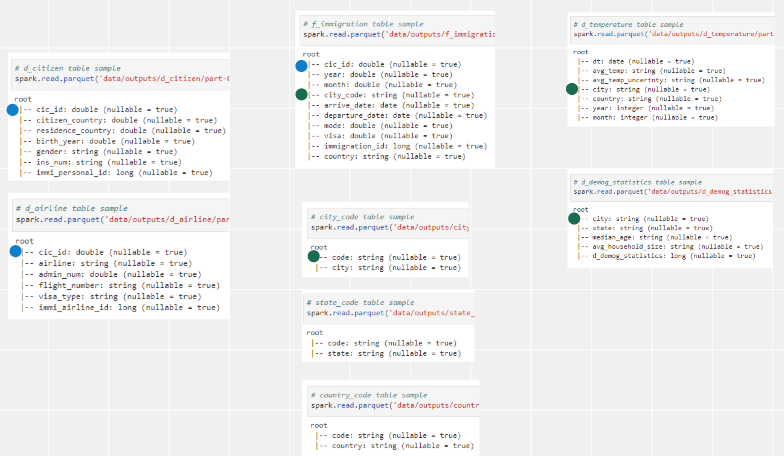

In [37]:
from IPython import display
display.Image("./data-model.png")

This data lake will be used to implement a data warehouse so a star schema is used and data analysts and data scientist can use this model to .

#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model

1. Extract all data sets from different sources, as CSV and SAS.
2. Carry out ETL, isolate fact and dimension tables, and clean data into required format;
    * Parse I94_SAS_Labels_Descriptions.SAS file to get auxiliary dimension table - country_code, city_code, state_code;
    * Tranform city, state in demography data to upper case to match city_code and state_code table;
    * Convert number of date in SAS to datetime
3. Store this information to in the AWS Redshift service;

**Check [etl file](./etl.ipynb) to see code.**

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

**Check [etl file](./etl.ipynb) to see code.**

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

**Check [Quality-checks file](./Quality-checks.ipynb) to see in details.**

#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

In [46]:
immigration_dict = pd.DataFrame(immigration_columns_description, immigration_df.columns, columns=['description'])
print("Immigration Data Dictionary\n")
print(immigration_dict)

print("\n")
print("Temperature Data Dictionary\n")
print(pd.DataFrame(world_temperature_description, temp_df.columns, columns=['description']))

print("\n")
print("Demographics Data Dictionary\n")
print(pd.DataFrame(us_cities_demographics_description, demography_df.columns, columns=['description']))

print("\n")
print("Airport Data Dictionary\n")
print(pd.DataFrame(airport_description, airport_df.columns, columns=['description']))

Immigration Data Dictionary

                                                description
cicid     ID that uniquely identify one record in the da...
i94yr                                           Year (YYYY)
i94mon                                           Month (MM)
i94cit                                     Born City number
i94res                                 Resident City number
i94port                                     Port Short Code
arrdate                                        Arrival date
i94mode       Mode: ([1,2,3,9],['Air','Sea', 'Land', 'NA'])
i94addr                        Arrival US States shortcodes
depdate                                      Departure date
i94bir                                    Age of respondent
i94visa   Visa codes: ([1,2,3],['Business', 'Tourism', '...
count                        for summary statistics propose
dtadfile                             Document date YYYYMMDD
visapost                   Department where Visa was issued
occup      

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.

#### Tools and Technologies
1. AWS S3 for data storage
2. Pandas for sample data set exploratory data analysis
3. PySpark for large data set data processing to transform staging table to dimensional table

#### Data Update Frequency
* Tables created from immigration and temperature data set should be updated on a monthly basis since the raw data set is built up monthly.
* Tables created from demography data set could be updated on an annual basis since it's data collection takes time.
* All tables should be updated in an append-only mode.

1. Data is increased 100x.


    If the data has been increased by 100x, I will use Spark so I can leverage distributed computing to process this data as it qualifies as big data. I can also make use of an EMR cluster in AWS alongside Spark

2. Data pipeline is run on daily basis by 7 am every day.


    In this case, I can use Apache Airflow to schedule and automate this data pipeline. There are other services similar to apache Airflow such as dagster and Luigi.

3. Database needs to be accessed by 100+ users simultaneously.


    In this scenario, AWS Redshift can handle this efficiently. If our provisioned nodes are not sufficient, we can scale our resources to cater to the increased workload.